In [266]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.colors import LogNorm
from os.path import join
from keras.layers import Dropout
from keras.models import load_model
import keras.backend as K
import seaborn as sns
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.fftpack import fft
from ipywidgets import interact, IntSlider, SelectionSlider
from bokeh.plotting import figure, show, output_notebook

In [148]:
path_start = "/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_noise"
models = ["poly_add_climate", "gan_000_climate", "gan_100_climate", "gan_101_climate", "gan_102_climate", "gan_103_climate"]
long_model_names = ["Polynomial", "GAN No Noise", "GAN Noise SD=1", "GAN Noise SD=0.1", "GAN Noise SD=0.01", "GAN Noise SD=0.001"]
#models = ["poly_add_climate", "gan_20_climate", "gan_05_climate", "gan_00_climate"]
#long_model_names = ["Polynomial", "GAN 20% Dropout", "GAN 5% Dropout", "GAN No Dropout"]
run = "02000000"
all_data = {}
for model in models:
    model_path = join(path_start, model, run)
    model_file = glob(model_path + "/*.nc")[0]
    all_data[model] = xr.open_dataset(model_file)

In [149]:
lorenz_data = xr.open_dataset(join(path_start, "lorenz_output.nc"))
start_index = 2000000
step_values = lorenz_data["step"].values
time_values = lorenz_data["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
x_vals = lorenz_data["lorenz_x"][l_start:l_end, 0].values
all_x = lorenz_data["lorenz_x"][l_start:l_end].values
u_vals = np.zeros((all_x.shape[0] - 1, all_x.shape[1]))
for i in range(all_x.shape[1]):
    u_vals[:, i] = (-all_x[:-1, i - 1] * (all_x[:-1, i - 2] - 
                       all_x[:-1, (i + 1) % all_x.shape[1]]) - all_x[:-1, i] + 20) - (all_x[1:, i] - all_x[:-1, i]) / 0.005
#y_vals = lorenz_data["lorenz_y"].values
lorenz_data.close()


In [217]:
x_bins = np.arange(-20, 26, 2)
u_bins = np.arange(-20, 30, 2)
true_hist, xb, ub = np.histogram2d(x_vals[:-1], u_vals[:, 0], bins=(x_bins, u_bins))
true_hist = np.where(true_hist == 0, np.nan, true_hist)
true_ut_hist, xb, ub = np.histogram2d(u_vals[:-1, 0], u_vals[1:, 0], bins=(u_bins, u_bins))
true_ut_hist = np.where(true_ut_hist == 0, np.nan, true_ut_hist)

0 AxesSubplot(0.125,0.536818;0.227941x0.343182)
1 AxesSubplot(0.398529,0.536818;0.227941x0.343182)
2 AxesSubplot(0.672059,0.536818;0.227941x0.343182)
3 AxesSubplot(0.125,0.125;0.227941x0.343182)
4 AxesSubplot(0.398529,0.125;0.227941x0.343182)
5 AxesSubplot(0.672059,0.125;0.227941x0.343182)


/Users/dgagne/anaconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


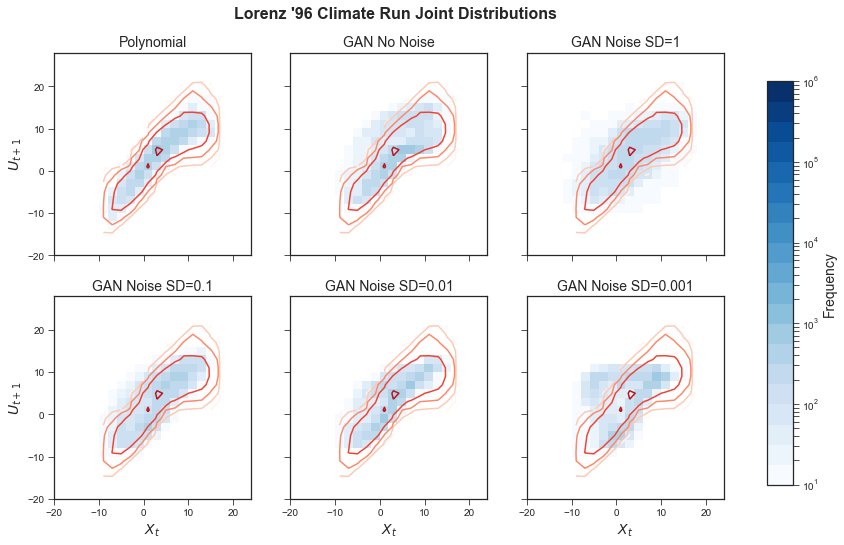

In [256]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
x_bins = np.arange(-20, 26, 2)
u_bins = np.arange(-20, 30, 2)
for a, ax in enumerate(axes.ravel()):
    print(a, ax)
    h, xb, yb, ha = ax.hist2d(all_data[models[a]]["x"][:10000, 0].values, all_data[models[a]]["u"][:10000, 0].values, bins=(x_bins, u_bins),
              cmin=1, norm=LogNorm(10, 1000000), cmap=plt.get_cmap("Blues", 20))
    ax.contour(0.5 * (x_bins[:-1] + x_bins[1:]), 0.5 * (u_bins[:-1] + u_bins[1:]), true_hist.T, 
               np.array([10, 100, 1000, 10000, 100000, 1000000]),
               norm=LogNorm(10, 1000000), cmap="Reds")
    ax.set_title(long_model_names[a], fontsize=14)
    if a > 2:
        ax.set_xlabel("$X_t$", fontsize=14)
    if a in [0, 3]:
        ax.set_ylabel("$U_{t+1}$", fontsize=14)
fig.subplots_adjust(top=0.9, right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(ha, cax=cbar_ax, )
cbar_ax.set_ylabel("Frequency", fontsize=14)
fig.suptitle("Lorenz '96 Climate Run Joint Distributions", fontsize=16, fontweight="bold", x=0.52, y=0.98)
plt.savefig("l96_climate_joint_hist.png", dpi=200, bbox_inches="tight")

0 AxesSubplot(0.125,0.536818;0.227941x0.343182)
1 AxesSubplot(0.398529,0.536818;0.227941x0.343182)
2 AxesSubplot(0.672059,0.536818;0.227941x0.343182)
3 AxesSubplot(0.125,0.125;0.227941x0.343182)
4 AxesSubplot(0.398529,0.125;0.227941x0.343182)
5 AxesSubplot(0.672059,0.125;0.227941x0.343182)


/Users/dgagne/anaconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


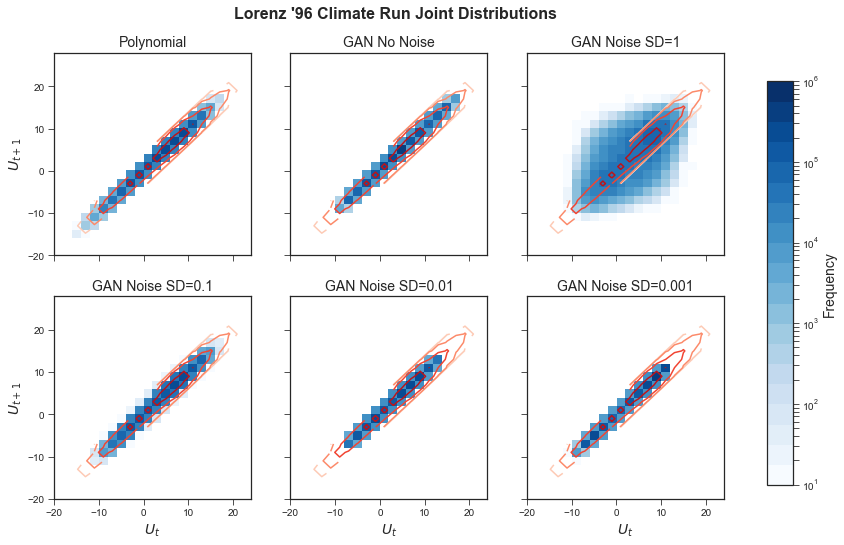

In [220]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
x_bins = np.arange(-20, 26, 2)
u_bins = np.arange(-20, 30, 2)
for a, ax in enumerate(axes.ravel()):
    print(a, ax)
    h, xb, yb, ha = ax.hist2d(all_data[models[a]]["u"][:-1, 0].values, all_data[models[a]]["u"][1:, 0].values, bins=(x_bins, u_bins),
              cmin=1, norm=LogNorm(10, 1000000), cmap=plt.get_cmap("Blues", 20))
    ax.contour(0.5 * (u_bins[:-1] + u_bins[1:]), 0.5 * (u_bins[:-1] + u_bins[1:]), true_ut_hist.T, 
               np.array([10, 100, 1000, 10000, 100000, 1000000]),
               norm=LogNorm(10, 1000000), cmap="Reds")
    ax.set_title(long_model_names[a], fontsize=14)
    if a > 2:
        ax.set_xlabel("$U_t$", fontsize=14)
    if a in [0, 3]:
        ax.set_ylabel("$U_{t+1}$", fontsize=14)
fig.subplots_adjust(top=0.9, right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(ha, cax=cbar_ax, )
cbar_ax.set_ylabel("Frequency", fontsize=14)
fig.suptitle("Lorenz '96 Climate Run Joint Distributions", fontsize=16, fontweight="bold", x=0.52, y=0.98)
plt.savefig("l96_climate_joint_ut_hist.png", dpi=200, bbox_inches="tight")

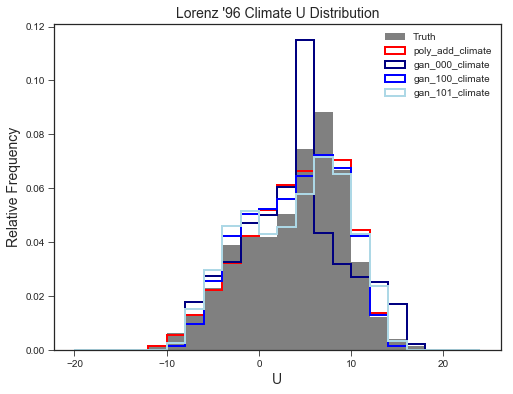

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
true_vals = [u_vals[:, 0]]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "navy", "blue", "lightblue", "green", "yellowgreen"]
for a, ax in enumerate([axes]):
    ax.hist(true_vals[a], color="gray", bins=bin_vals[a], density=True, label="Truth")
    for m, model in enumerate(models):
        ax.hist(all_data[model][var_names[a]][:, 0].values, histtype="step", 
                color=m_colors[m], bins=bin_vals[a], lw=2, density=True, label=long_model_names[m])
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("Relative Frequency", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_hist.png", dpi=200, bbox_inches="tight")

In [51]:
def hellinger(a, b):
    return np.sqrt(np.sum((np.sqrt(a) - np.sqrt(b)) ** 2)) / np.sqrt(2)

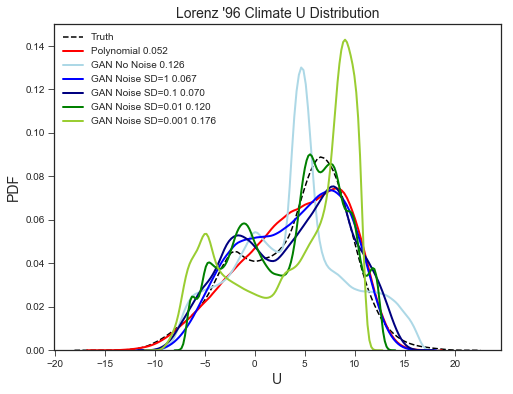

In [152]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
true_vals = [u_vals[:, 1]]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "lightblue", "blue", "navy","green", "yellowgreen"]
u_pdf_vals = np.linspace(-20, 20, 20)
for a, ax in enumerate([axes]):
    kde_true = KDEUnivariate(true_vals[a])
    kde_true.fit(gridsize=100)
    true_pdf = kde_true.evaluate(u_pdf_vals)
    sns.kdeplot(true_vals[a], color="k", ax=ax, ls="--", gridsize=100, label="Truth")
    for m, model in enumerate(models):
        kde_model = KDEUnivariate(all_data[model][var_names[a]][:, 1].values.astype(np.float64))
        kde_model.fit(gridsize=100)
        model_pdf = kde_model.evaluate(u_pdf_vals)
        sns.kdeplot(all_data[model][var_names[a]][:, 0].values, gridsize=100,
                color=m_colors[m], lw=2, ax=ax, label=long_model_names[m] + " {0:0.3f}".format(hellinger(true_pdf, model_pdf)))
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_u_hist.png", dpi=200, bbox_inches="tight")

In [267]:
output_notebook()

Loading BokehJS ...

In [276]:
all_data["gan_103_climate"]

<xarray.Dataset>
Dimensions:  (step: 2000000, time: 2000000, x_size: 8)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * x_size   (x_size) int64 0 1 2 3 4 5 6 7
  * time     (time) float64 0.0 0.005 0.01 0.015 0.02 0.025 0.03 0.035 0.04 ...
Data variables:
    x        (step, x_size) float32 ...
    u        (step, x_size) float32 ...
    u_res    (step, x_size) float32 ...
Attributes:
    initial_step:  2000000
    member:        0
    u_model_path:  /glade2/work/dgagne/exp_20_noise/gan_generator_0103_epoch_...

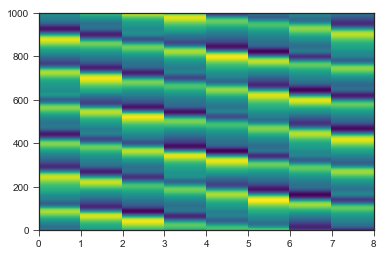

In [344]:
plt.pcolormesh(all_data["gan_000_climate"]["x"][40000:41000, :].values, cmap="viridis")

In [326]:
50 / 0.005

10000.0

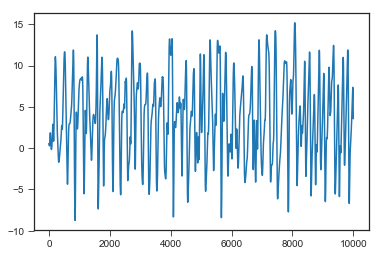

In [342]:
plt.plot(all_data["gan_000_climate"]["x"][100000:110000, 2].values)

In [322]:
def wave_plot(time, model, var):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True)
    ax.plot(np.arange(0, 360, 45) * np.pi / 180, all_data[model][var][time], 'ko-')
    plt.ylim(-20, 20)
    plt.show()
interact(wave_plot, time=(0, 10000, 20), model=models, var=["x", "u"])

interactive(children=(IntSlider(value=5000, description='time', max=10000, step=20), Dropdown(description='mod…

<function __main__.wave_plot(time, model, var)>

In [280]:
f = figure()
f.line(all_data["gan_103_climate"]["time"].values[0:50000], all_data["gan_103_climate"]["x"][:50000, 0].values, line_color="red")
f.line(all_data["gan_100_climate"]["time"].values[0:50000], all_data["gan_100_climate"]["x"][:50000, 0].values, line_color="purple")

show(f)

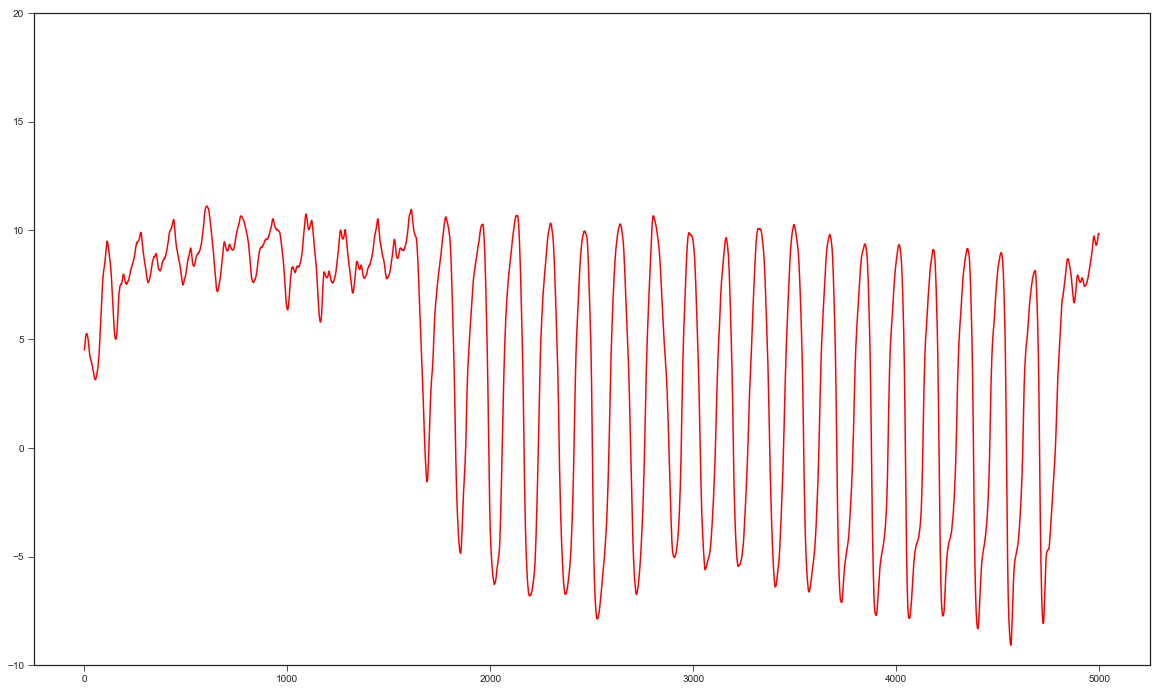

In [258]:
plt.figure(figsize=(20, 12))
plt.ylim(-10, 20)
#plt.plot(all_data["gan_000_climate"]["x"][:, 0].values[100000:100000 + 5000], "b-", label="GAN")
plt.plot(all_data["gan_103_climate"]["u"][:, 0].values[100000:100000 + 5000], "r-", label="GAN")

#plt.plot(u_vals[:1000, 0], "k-", label="Truth")

/Users/dgagne/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


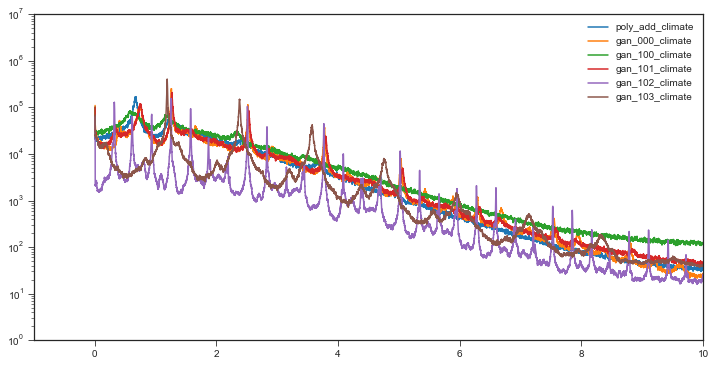

In [210]:
plt.figure(figsize=(12, 6))
T = 0.005
N = all_data["gan_101_climate"]["x"][:, 0].values.size
for model in models:
    fft_mod = fft(all_data[model]["x"][:, 0].values)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    plt.semilogy(xf, pd.rolling_mean(np.abs(fft_mod[:N//2]), 100), label=model)
    plt.xlim(-1, 10)
    plt.ylim(1, 1e7)
plt.legend()

In [186]:
fft_mod

array([ 7.1748505e+06    +0.j    ,  2.3367414e+04 +6991.0264j,
       -8.4060586e+03+30260.664j , ...,  4.7221279e+03+12981.595j ,
       -8.4060586e+03-30260.664j ,  2.3367414e+04 -6991.0264j],
      dtype=complex64)

In [153]:
u_pdf_vals = np.linspace(-15, 25, 50)
kde_true = KDEUnivariate(u_vals[:, 0])
kde_true.fit(gridsize=50)
true_pdf = kde_true.evaluate(u_pdf_vals)
model_pdfs = np.zeros((len(models), u_pdf_vals.size))
hellinger_scores = np.zeros(len(models))
for m, model in enumerate(models):
    kde_model = KDEUnivariate(all_data[model]["u"][:, 0].values.astype(np.float64))
    kde_model.fit(gridsize=50)
    model_pdfs[m] = kde_model.evaluate(u_pdf_vals)
    hellinger_scores[m] = hellinger(true_pdf, model_pdfs[m])

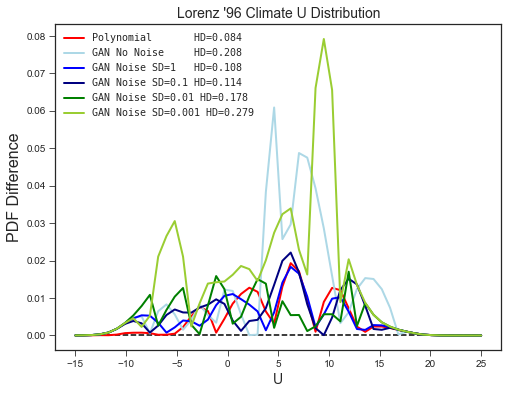

In [154]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
m_colors = ["red", "lightblue", "blue", "navy","green", "yellowgreen"]
for a, ax in enumerate([axes]):
    plt.plot(u_pdf_vals, np.zeros(u_pdf_vals.size), 'k--')
    for m, model in enumerate(models):
        ax.plot(u_pdf_vals, np.abs(model_pdfs[m] - true_pdf),
                color=m_colors[m], lw=2, label="{0:16} HD={1:0.3f}".format(long_model_names[m], 
                                                                         hellinger_scores[m]))
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF Difference", fontsize=16)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend(fontsize=12, prop={"family":"monospace"})
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_u_hist_diff.png", dpi=200, bbox_inches="tight")

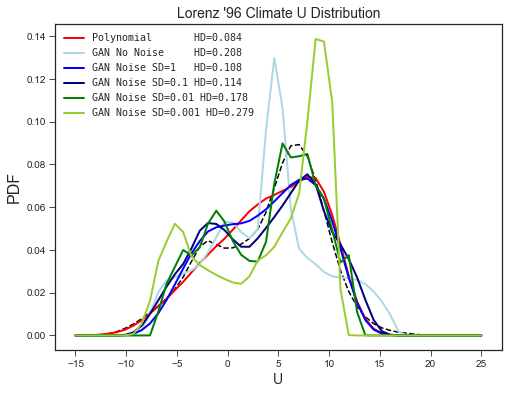

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
m_colors = ["red", "lightblue", "blue", "navy","green", "yellowgreen"]
for a, ax in enumerate([axes]):
    plt.plot(u_pdf_vals, true_pdf, 'k--')
    for m, model in enumerate(models):
        ax.plot(u_pdf_vals, model_pdfs[m],
                color=m_colors[m], lw=2, label="{0:16} HD={1:0.3f}".format(long_model_names[m], 
                                                                           hellinger_scores[m]))
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF", fontsize=16)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend(fontsize=12, prop={"family":"monospace"})
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_u_hist.png", dpi=200, bbox_inches="tight")

In [222]:
all_data[model][var_names[a]].shape[0]

(2000000, 8)

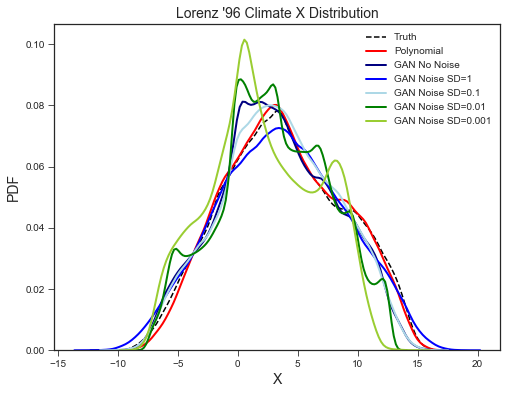

In [224]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["x"]
true_vals = [x_vals]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "navy", "blue", "lightblue", "green", "yellowgreen"]
for a, ax in enumerate([axes]):
    sns.kdeplot(true_vals[a], color="k", ax=ax, ls="--", gridsize=100, label="Truth")
    for m, model in enumerate(models):
        sns.kdeplot(all_data[model][var_names[a]][1000000:, 0].values, gridsize=100,
                color=m_colors[m], lw=2, ax=ax, label=long_model_names[m])
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_x_hist.png", dpi=200, bbox_inches="tight")

In [37]:
lags = np.arange(1, 200)
x_lag_corrs = np.zeros((len(models), lags.size))
true_lag_corrs = np.zeros(lags.size)
for m, model in enumerate(models):
    print(model)
    model_x_values = all_data[model]["x"][:, 0].values
    for l, lag in enumerate(lags):
        x_lag_corrs[m, l] = np.corrcoef(model_x_values[:-lag], 
                                        model_x_values[lag:])[0, 1]
for l, lag in enumerate(lags):
    true_lag_corrs[l] = np.corrcoef(x_vals[:-lag], 
                                    x_vals[lag:])[0, 1]

poly_add_climate
gan_000_climate
gan_100_climate
gan_101_climate
gan_102_climate
gan_103_climate


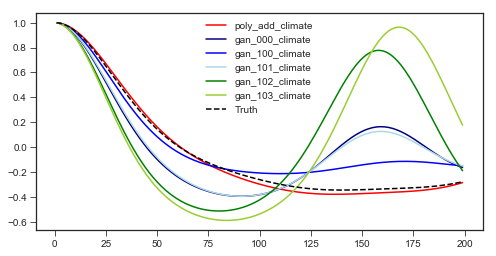

In [38]:
plt.figure(figsize=(8, 4))
for m, model in enumerate(models):
    plt.plot(lags, x_lag_corrs[m], color=m_colors[m], label=long_model_names[m])
plt.plot(lags, true_lag_corrs, "k--", label="Truth")
plt.legend()


Text(0,0.5,'Correlation Difference')

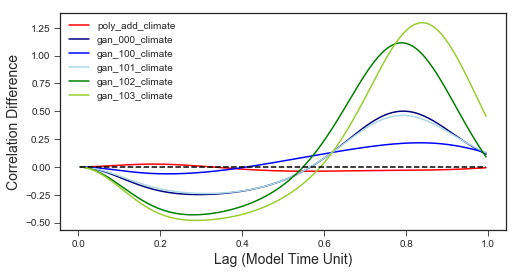

In [39]:
plt.figure(figsize=(8, 4))
for m, model in enumerate(models):
    plt.plot(lags / 200, x_lag_corrs[m] - true_lag_corrs, color=m_colors[m], label=long_model_names[m])
plt.legend()
plt.plot(lags / 200, np.zeros(lags.shape), 'k--')
plt.xlabel("Lag (Model Time Unit)", fontsize=14)
plt.ylabel("Correlation Difference", fontsize=14)

In [88]:
np.corrcoef(x_vals[:-1], x_vals[1:])

array([[ 1.       ,  0.9993089],
       [ 0.9993089,  1.       ]])

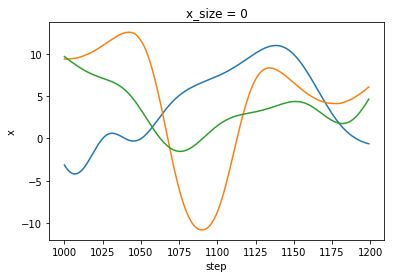

In [8]:
all_data["gan_00_climate"]["x"][1000:1200,0].plot()
all_data["gan_20_climate"]["x"][1000:1200,0].plot()
all_data["poly_add_climate"]["x"][1000:1200,0].plot()

In [ ]:
gan_loss = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_loss_history_0000.csv", index_col="Time")

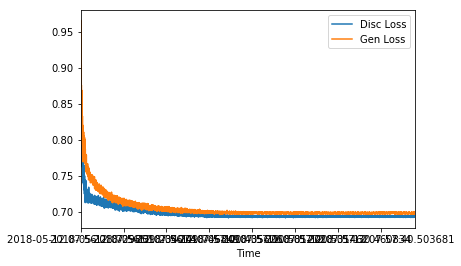

In [25]:
gan_loss[["Disc Loss", "Gen Loss"]].plot()

In [68]:
d_input = K.placeholder(shape=(16, ))
d_func = K.function([d_input, K.learning_phase()], [Dropout(0.5)(d_input)])

In [70]:
d_func([np.ones((16)), 1])

[array([ 0.,  0.,  2.,  2.,  2.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,
         2.,  2.,  2.], dtype=float32)]

In [99]:
train_data = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/lorenz_combined_output.csv")

In [106]:
train_data.columns["X_t"]

Index(['x_index', 'step', 'time', 'u_scale', 'X_t', 'Uy_t', 'Uy_t+1', 'Ux_t',
       'Ux_t+1', 'Y_t_0', 'Y_t_1', 'Y_t_2', 'Y_t_3', 'Y_t_4', 'Y_t_5', 'Y_t_6',
       'Y_t_7', 'Y_t_8', 'Y_t_9', 'Y_t_10', 'Y_t_11', 'Y_t_12', 'Y_t_13',
       'Y_t_14', 'Y_t_15', 'Y_t_16', 'Y_t_17', 'Y_t_18', 'Y_t_19', 'Y_t_20',
       'Y_t_21', 'Y_t_22', 'Y_t_23', 'Y_t_24', 'Y_t_25', 'Y_t_26', 'Y_t_27',
       'Y_t_28', 'Y_t_29', 'Y_t_30', 'Y_t_31', 'Y_t+1_0', 'Y_t+1_1', 'Y_t+1_2',
       'Y_t+1_3', 'Y_t+1_4', 'Y_t+1_5', 'Y_t+1_6', 'Y_t+1_7', 'Y_t+1_8',
       'Y_t+1_9', 'Y_t+1_10', 'Y_t+1_11', 'Y_t+1_12', 'Y_t+1_13', 'Y_t+1_14',
       'Y_t+1_15', 'Y_t+1_16', 'Y_t+1_17', 'Y_t+1_18', 'Y_t+1_19', 'Y_t+1_20',
       'Y_t+1_21', 'Y_t+1_22', 'Y_t+1_23', 'Y_t+1_24', 'Y_t+1_25', 'Y_t+1_26',
       'Y_t+1_27', 'Y_t+1_28', 'Y_t+1_29', 'Y_t+1_30', 'Y_t+1_31'],
      dtype='object')

In [116]:
del gen_models[:]

In [225]:
model_files = sorted(glob("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_noise/gan_generator_0102_epoch*.h5"))
epochs = np.zeros(len(model_files))
gen_models = []
for m, model_file in enumerate(model_files):
    epoch = int(model_file.split("/")[-1].split("_")[-1][:4])
    print(epoch)
    epochs[m] = epoch
    gen_models.append(load_model(model_file))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
24
26
28
30
32
34
36
38
40


In [4]:
epochs = np.arange(1, 31)
gen_models = []
for epoch in epochs:
    print(epoch)
    gen_models.append(load_model("/Users/dgagne/lorenz_gan/exp_travis/gan_generator_0000_epoch_{0:04d}.h5".format(epoch)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [106]:
x_scaling_values = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_X_scaling_values_0005.csv",
                              index_col="Channel")
y_scaling_values = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_Y_scaling_values_0005.csv",
                              index_col="Channel")

In [226]:
preds = []
for g, gen_model in enumerate(gen_models):
    pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
    preds.append(pred_func([(train_data[["X_t", "Ux_t"]] 
                             - x_scaling_values["mean"].values) / x_scaling_values["std"].values, 
                            np.random.normal(size=(train_data.shape[0], 1)), 1]))
    

In [7]:
sns.set_style("ticks")

In [227]:
def plot_kde(epoch):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(train_data["Ux_t+1"], color="r", ls="--", label="Truth")
    sns.kdeplot(preds[np.where(epochs==epoch)[0][0]][0].ravel() * y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"], 
                color="k", label="GAN Epoch {0:02d}".format(epoch))
    plt.xlim(-15, 20)
    plt.ylim(0, 0.2)
    plt.legend()
    plt.title("GAN U Distribution Epoch {0:02d}".format(epoch), fontsize=14)
    plt.xlabel("Subgrid Forcing U", fontsize=14)
    plt.ylabel("PDF", fontsize=14)
interact(plot_kde, epoch=SelectionSlider(options=epochs.astype(int)))
    

interactive(children=(SelectionSlider(description='epoch', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.plot_kde(epoch)>

In [12]:
for e in range(1, 31):
    plot_kde(e)
    plt.savefig("gan_dist/gan_u_dist_e_{0:02d}.png".format(e), dpi=200, bbox_inches="tight")
    plt.close()

In [11]:
kde_true = KDEUnivariate(train_data["Ux_t+1"])
kde_true.fit(gridsize=100)
u_points = np.arange(-15, 20.5, 0.5)
true_pdf = kde_true.evaluate(u_points)
def hellinger(a, b):
    return np.sqrt(np.sum((np.sqrt(a) - np.sqrt(b)) ** 2)) / np.sqrt(2)

def plot_kde_diff(epoch):
    kde_epoch = KDEUnivariate(preds[epoch - 1][0].ravel().astype(float)* y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"])
    kde_epoch.fit(gridsize=100)
    epoch_pdf = kde_epoch.evaluate(u_points)
    plt.plot(u_points, epoch_pdf)
    plt.plot(u_points, true_pdf)
    plt.title(hellinger(epoch_pdf, true_pdf))
interact(plot_kde_diff, epoch=IntSlider(1, 1, 30))

interactive(children=(IntSlider(value=1, description='epoch', max=30, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_kde_diff(epoch)>

In [41]:
epoch = 10
kde_epoch = KDEUnivariate(preds[epoch - 1][0].ravel().astype(float) * y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"])
kde_epoch.fit(gridsize=100)
epoch_vals = kde_epoch.evaluate(u_points)

In [46]:
def hellinger(a, b):
    return np.sqrt(np.sum(np.sqrt(a) + np.sqrt(b))) / np.sqrt(2)
hellinger(true_pdf, epoch_vals)

3.1158748671508039

In [4]:
storm_gen = load_model("/d1/dgagne/spatial_storm_results_20171220/logistic_gan_0_generator.h5", compile=False)

In [11]:
storm_gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              266240    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
__________

In [34]:
rand_vec = np.random.normal(size=(1, 64))
out = storm_gen.predict(rand_vec)

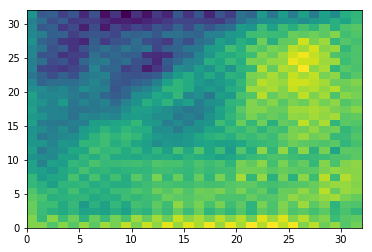

In [35]:
plt.pcolormesh(out[0, :, :, 14])

In [31]:
output_image = K.placeholder(storm_gen.output.shape)
loss = K.mean((storm_gen.output - output_image) ** 2)
back_grad = K.gradients(loss, [storm_gen.input])
back_func = K.function([output_image, storm_gen.input, K.learning_phase()], back_grad)

In [38]:
grad_vec = back_func([out, rand_vec, 0])[0]

In [39]:
grad_vec - rand_vec

array([[ 0.06119015, -1.45144983, -1.4650528 ,  0.72389829,  0.57435266,
         1.20375962,  0.11892127,  0.98309904, -0.66790656, -0.6346919 ,
         1.04753316,  1.35391103, -1.08669851,  0.67630246,  2.5168406 ,
        -0.5747017 , -0.16625034,  1.35881489, -1.08704259,  0.77239309,
        -0.64923575,  0.27184219, -1.22555029,  0.85657667,  1.69944132,
        -0.76888336,  2.14130663, -0.37890832, -1.11473635, -0.27178834,
         1.75480905, -0.95700945,  0.85619659, -0.32525141,  2.39589236,
        -0.48207776, -0.26152864, -0.49082541, -1.28558897, -0.90093777,
         0.6177793 , -0.92731069,  1.66803703,  0.46372245,  1.81123237,
         0.73409826,  0.07980821,  2.39512129, -1.62304525,  1.07564616,
         0.22523666,  0.66659512, -1.45823704, -0.14974203,  1.35642919,
        -0.28984689,  0.16560961, -0.60247137,  0.04683801,  0.55171271,
         0.10792367, -0.21464413,  0.87038535,  1.28929214]])

In [345]:
gen_models[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 3)            0           concatenate_1[0][0]              
__________

In [346]:
gen_models[-1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 3)            0           concatenate_1[0][0]              
__________

In [ ]:
gen_models[-1]